# Portfolio Simulator

When training machine learning models it is essential to perform cross validation to ensure we're not overfitting. To that end, I have constructed a portfolio simulator to test our models on loans they have not seen before.

The simulation works through the use of a Portfolio class I wrote. The Portfolio class is initialized with 6 parameters:

* `starting_balance`: How many dollars do you have to start investing with?
* `investment_per_loan`: How much do you want to invest per loan? Must be in increments of $25.
* `start_date`: The date the simulation begins its investing. Must be August 1st, 2017 or later because loans before that are included in the training set.
* `loans_df`: The dataframe containing the predicted ROI of all loans in the testing set. This is what was produced in the `Modeling` notebook.
* `payments_df`: The dataframe containing all payments from loans in the testing set.
* `min_roi`: You will not invest in a loan if it's predicted return on investment is below this minimum.

A portfolio class also makes use of a Loan class that I created. The necessary classes and functions are contained in the `src/portfolio.py` file. The simulation works in the following manner:

1. Create a portfolio with a certain amount of cash available to invest, let's say $20,000, beginning in August 2017. 
2. Select all loans available to invest in this month, and the predicted ROI from our trained model.
3. Filter out loans with a predicted ROI lower than the minimum we're looking for.
4. Invest $`investment_per_loan` into as many loans as possible given the portfolio's current cash balance and add these loans to the portfolio.
5. Check if any loans in the portfolio have made payments this month. If they have them add their payments to the portfolio's available cash balance.
6. Check if any loans in the portfolio have defaulted. If so remove them from the portfolio and consider their remaining balance as lost.
7. Advance the date by one month and then repeat steps 2-6 until the simulation hits the ending date of 2020-07-01.

If the predictions from our trained machine learning model(s) are accurate then we should be able to select profitable loans. We can compare different models by running portfolio simulations and seeing how the final portfolio balance changes.

Remember, these model predictions were made on loans that the models had not been trained on. It is essential to perform cross validation on unseen data.

In [1]:
import pandas as pd
import numpy as np
import datetime
from src.portfolio import *
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# The simulations need only payments that are from loans in the testing set.
payments = pd.read_pickle('data/df_payments_testing_loans.pkl.bz2', compression='bz2')
payments.tail()

RECEIVED_AMT_INVESTORS  PBAL_END_PERIOD_INVESTORS  \
RECEIVED_D LOAN_ID                                                        
2020-08-01 169182703              650.169983                3418.959961   
           169185346              669.049988                 851.140015   
           169188486              218.490005                3315.239990   
           169195300              227.520004                5311.250000   
           169225459             1394.140015                1560.839966   

                     IssuedDate  mths_since_issue  
RECEIVED_D LOAN_ID                                 
2020-08-01 169182703 2020-06-01                 2  
           169185346 2020-06-01                 2  
           169188486 2020-06-01                 2  
           169195300 2020-06-01                 2  
           169225459 2020-06-01                 2

Next let's read in the predictions that our trained models have already made for the loans in the testing set.

In [3]:
predictions_xgb = pd.read_pickle('data/model_xgb_predictions.pkl.bz2')
predictions_dt =  pd.read_pickle('data/model_dt_predictions.pkl.bz2')
predictions_gbrt =  pd.read_pickle('data/model_gbrt_predictions.pkl.bz2')
predictions_rf = pd.read_pickle('data/model_rf_predictions.pkl.bz2')
predictions_lgbm = pd.read_pickle('data/model_lgbm_predictions.pkl.bz2')
predictions_catboost = pd.read_pickle('data/model_catboost_predictions.pkl.bz2')
predictions_random = pd.read_pickle('data/model_random_pick.pkl.bz2')
predictions_high_interest = pd.read_pickle('data/model_high_interest_rate.pkl.bz2')
predictions_low_interest = pd.read_pickle('data/model_low_interest_rate.pkl.bz2')

In [26]:
# Ensemble Catboost, LightGBM, and XGBoost
predictions_ensemble = predictions_xgb.copy()
predictions_ensemble['predicted_roi'] = (predictions_xgb['predicted_roi'] + predictions_lgbm['predicted_roi'] + predictions_catboost['predicted_roi'])/3

Let's define some variables we'll be using repeatedly for the simulations.

In [27]:
start_date = datetime.date(2017,8,1)
end_date = datetime.date(2020,7,1)
starting_balance = 50000
investment_per_loan = 100
min_roi = 10.0

In [28]:
def get_annualized_roi(dates, balances):
    num_months = len(dates)
    starting_balance = balances[0]
    ending_balance = balances[-1]
    profit = ending_balance - starting_balance
    return 100 * (((1+(profit/starting_balance))**(1/num_months))**12 - 1)

def simulate_loan_investment_portfolio(all_payments, model_predictions, start_date, end_date, starting_balance, investment_per_loan, min_roi):
    # To speed up the simulation we can look at just the payments from loans matching our minimum ROI criteria. 
    loans_meeting_min_roi = model_predictions.loc[model_predictions['predicted_roi'] >= min_roi, 'id']
    # We don't need to bother grabbing the mths_since_issue columns. That was only needed for calculating ROI.
    payments_filtered = all_payments.loc[all_payments.index.get_level_values(1).isin(loans_meeting_min_roi), ['RECEIVED_AMT_INVESTORS', 'PBAL_END_PERIOD_INVESTORS', 'IssuedDate']]
    
    dates = []
    balances = []
    
    portfolio = Portfolio(starting_balance, investment_per_loan, start_date, model_predictions, payments_filtered, min_roi)
    while portfolio.date < end_date:
        dates.append(portfolio.date)
        balances.append(portfolio.total_balance)
        portfolio.simulate_month()
        
    roi = get_annualized_roi(dates, balances)
        
    return dates, balances, roi

In [29]:
dates, balances_xgb, roi_xgb = simulate_loan_investment_portfolio(payments, predictions_xgb, start_date, 
                                                                end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_dt, roi_dt = simulate_loan_investment_portfolio(payments, predictions_dt, start_date, 
                                                              end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_gbrt, roi_gbrt = simulate_loan_investment_portfolio(payments, predictions_gbrt, start_date,
                                                                    end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_rf, roi_rf = simulate_loan_investment_portfolio(payments, predictions_rf, start_date,
                                                                    end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_catboost, roi_catboost = simulate_loan_investment_portfolio(payments, predictions_catboost, start_date,
                                                                            end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_lgbm, roi_lgbm = simulate_loan_investment_portfolio(payments, predictions_lgbm, start_date, 
                                                                    end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_random, roi_random = simulate_loan_investment_portfolio(payments, predictions_random, start_date,
                                                                        end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_high_interest, roi_high_interest = simulate_loan_investment_portfolio(payments, predictions_high_interest, start_date,
                                                                                      end_date, starting_balance, investment_per_loan, min_roi)
dates, balances_low_interest, roi_low_interest = simulate_loan_investment_portfolio(payments, predictions_low_interest, start_date,
                                                                                    end_date, starting_balance, investment_per_loan, -11.0)

dates, balances_ensemble, roi_ensemble = simulate_loan_investment_portfolio(payments, predictions_ensemble, start_date, 
                                                                end_date, starting_balance, investment_per_loan, min_roi)

Now that we've run portfolio simulations for our 9 models, let's put the results into a dataframe so we can compare portfolios.

In [30]:
portfolio_values = pd.DataFrame(index=dates, data=balances_xgb)
portfolio_values.rename(columns={0:'XGBoost'}, inplace=True)
portfolio_values['decision_tree'] = balances_dt
portfolio_values['gradient_boosting'] = balances_gbrt
portfolio_values['random_forest'] = balances_rf
portfolio_values['lgbm'] = balances_lgbm
portfolio_values['CatBoost'] = balances_catboost
portfolio_values['high_interest'] = balances_high_interest
portfolio_values['low_interest'] = balances_low_interest
portfolio_values['random_loans'] = balances_random
portfolio_values['ensemble'] = balances_ensemble
portfolio_values.head()

,XGBoost,decision_tree,gradient_boosting,random_forest,lgbm,CatBoost,high_interest,low_interest,random_loans,ensemble
2017-08-01,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
2017-09-01,50005.342656,50005.902612,50000.333333,50000.000000,50000.570043,50000.570043,50004.297239,50000.930975,50002.895389,50000.570043
2017-10-01,50682.824108,50818.194079,50053.847777,50255.273268,50223.360541,50129.699885,50939.945632,50213.322287,50426.677759,50272.966558
2017-11-01,51474.862571,51812.088065,50175.484798,50730.075708,50658.504241,50428.849326,52074.075176,50429.585813,50924.184871,50861.778029
2017-12-01,52271.316393,52801.901189,50363.358837,51391.943827,51367.135305,50883.436915,53193.848614,50642.993575,51421.524995,51701.579481


In [31]:
portfolio_values.tail()

,XGBoost,decision_tree,gradient_boosting,random_forest,lgbm,CatBoost,high_interest,low_interest,random_loans,ensemble
2020-02-01,71879.354013,61007.394156,67828.399567,66200.268081,71623.716978,70776.138773,57269.278744,55831.235968,54875.649073,73498.339070
2020-03-01,72786.326746,60611.557231,68676.395218,66779.903007,72674.429326,71598.527871,57359.546903,56071.560564,55124.348925,74450.787896
2020-04-01,73285.169976,60831.658457,69666.665439,67613.208649,73768.104594,72527.051931,57759.569339,56115.080059,55356.269643,75409.866896
2020-05-01,73991.867595,61270.357920,70422.682666,68280.623960,74664.515157,73495.491877,57807.514068,56235.377410,55519.711066,76174.630480
2020-06-01,74677.973097,61946.647341,71336.863745,68895.907999,75705.328920,74613.041736,57263.443930,56472.426942,55884.687693,77119.135508


Let's create a plot to see which model performed the best in our simulations.

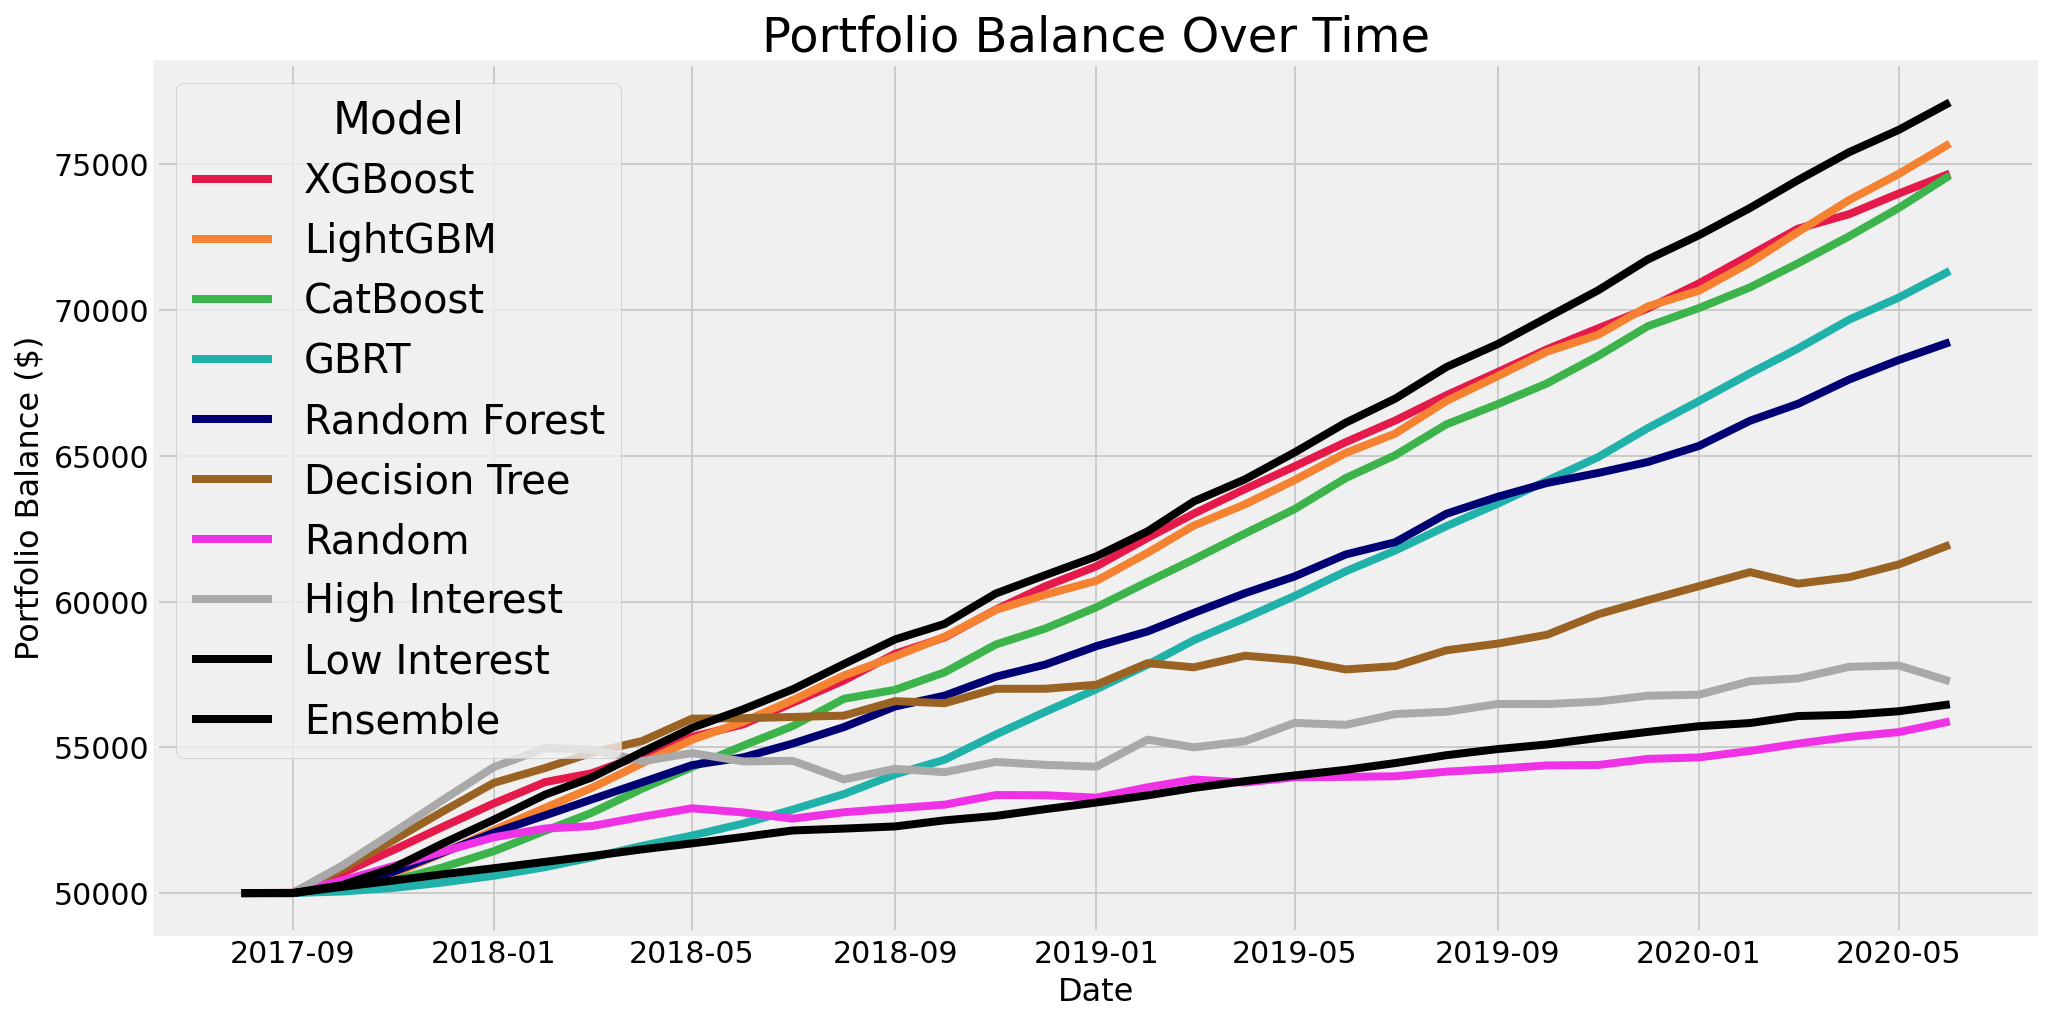

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dates, balances_xgb, color='#e6194B', label='XGBoost')
ax.plot(dates, balances_lgbm, color='#f58231', label='LightGBM')
ax.plot(dates, balances_catboost, color='#3cb44b', label='CatBoost')
ax.plot(dates, balances_gbrt, color='lightseagreen', label='GBRT')
ax.plot(dates, balances_rf, color='#000075', label='Random Forest')
ax.plot(dates, balances_dt, color='#9A6324', label='Decision Tree')
ax.plot(dates, balances_random, color='#f032e6', label='Random')
ax.plot(dates, balances_high_interest, color='#a9a9a9', label='High Interest')
ax.plot(dates, balances_low_interest, color='#000000', label='Low Interest')
ax.plot(dates, balances_ensemble, color='#000000', label='Ensemble')
ax.set_title('Portfolio Balance Over Time', fontsize=24)
ax.set_ylabel('Portfolio Balance ($)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(axis='x', labelsize=15)
ax.legend(fontsize=20, title_fontsize=22, title='Model');

The untuned XGBoost model saw performance far superior to any other model. Additionally, selecting the lowest interest rate loans had essentially the same performance as just selecting loans randomly. For nearly a year it seems selecting loans with high interest rates was better than XGBoost, but it looks like those loans defaulted over time, giving the XGBoost model the advantage.

It will be interesting to see how performance changes once I add more models and do hyperparameter tuning.

Now that we can see the LightGBM predictions are currently our best options, let's use the simulator to determine what `minimum_roi` parameter value would've given us the best return, given that we have \\$50,000 to invest and are investing $100 per loan.

In [35]:
min_rois = np.linspace(6, 24, num=100)
rois = []
balances = []

for roi in min_rois:
    _, balance, portfolio_roi = simulate_loan_investment_portfolio(payments, predictions_ensemble, start_date, end_date, starting_balance, investment_per_loan, roi)
    rois.append(portfolio_roi)
    balances.append(balance[-1])

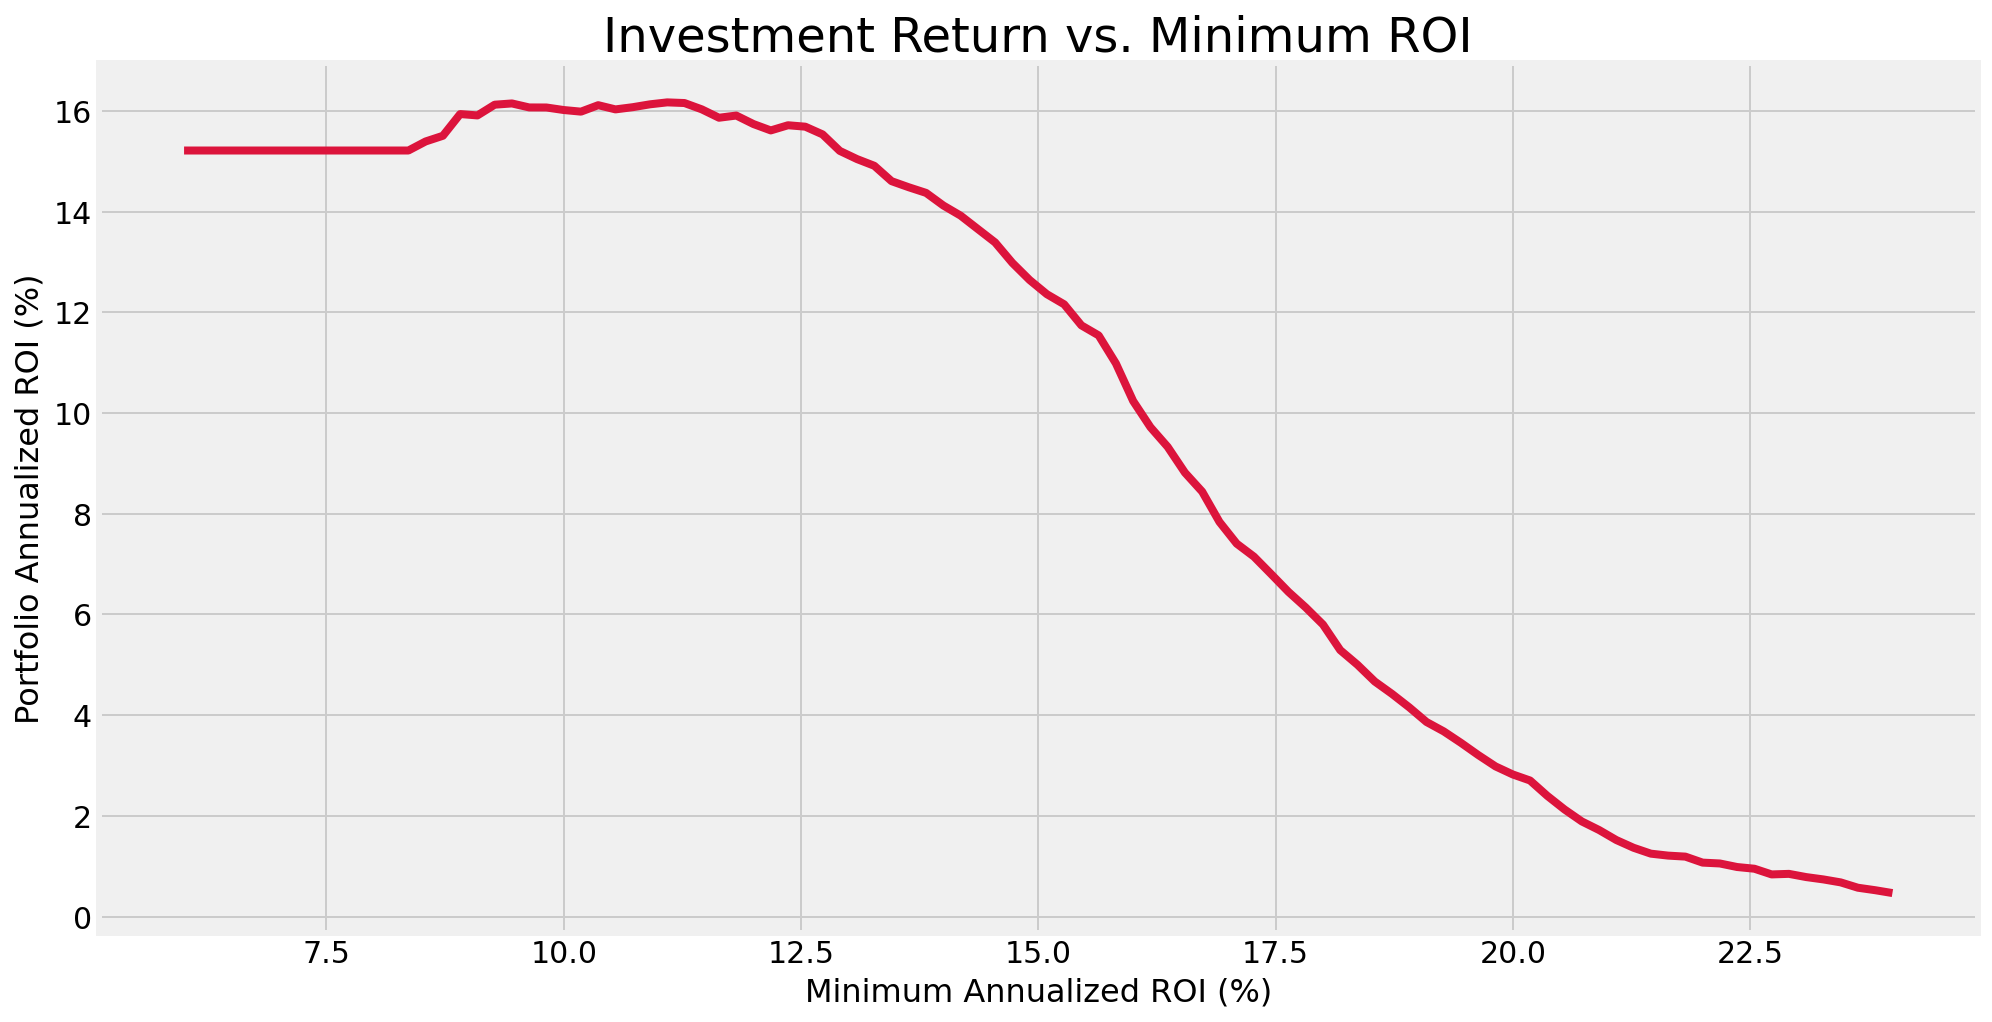

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(min_rois, rois, color='crimson')
ax.set_title('Investment Return vs. Minimum ROI', fontsize=24)
ax.set_ylabel('Portfolio Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Minimum Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

To satisfy my curiosity, let's also look at the maximum ROI we could've gotten with the `CatBoost` and `XGBoost` models.

In [14]:
min_rois = np.linspace(8, 20, num=10)
rois = []
balances = []

for roi in min_rois:
    _, balance, portfolio_roi = simulate_loan_investment_portfolio(payments, predictions_xgb, start_date, end_date, starting_balance, investment_per_loan, roi)
    rois.append(portfolio_roi)
    balances.append(balance[-1])

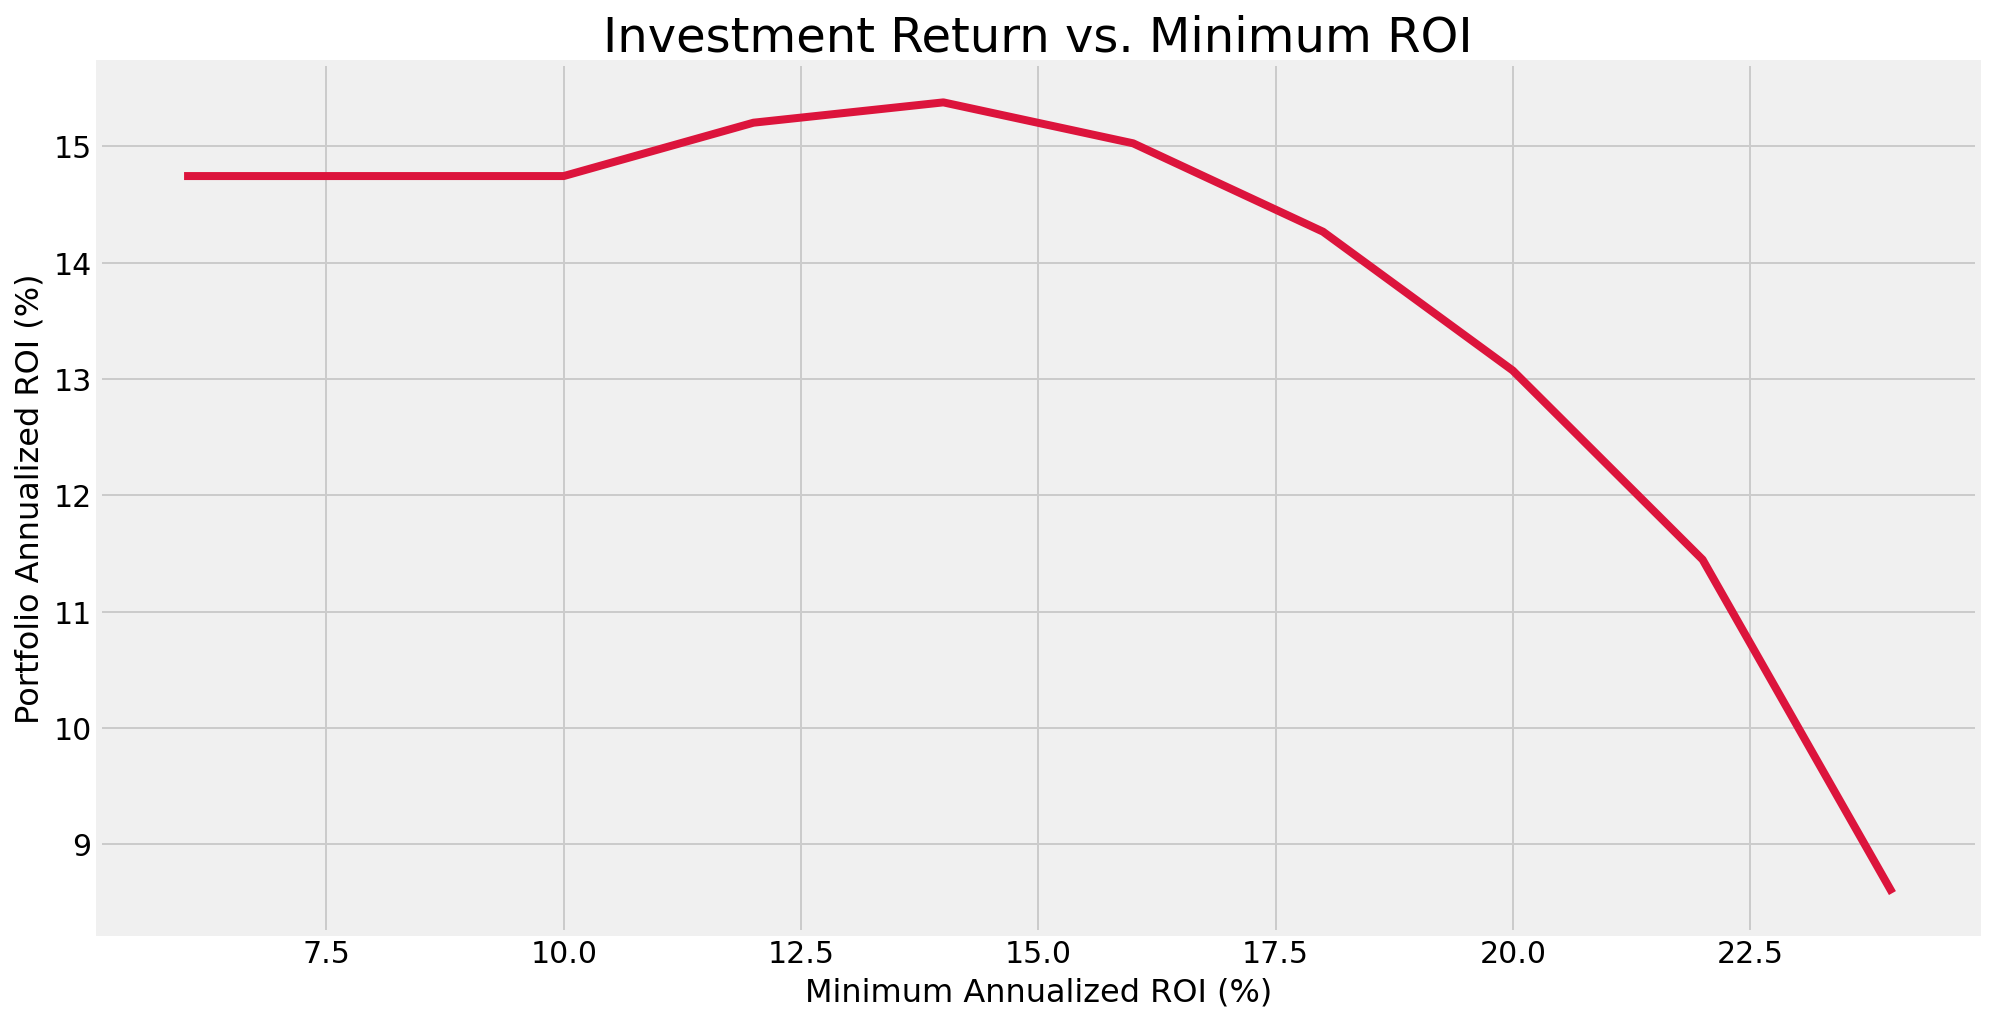

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(min_rois, rois, color='crimson')
ax.set_title('Investment Return vs. Minimum ROI', fontsize=24)
ax.set_ylabel('Portfolio Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Minimum Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

In [ ]:
i_best = np.argmax(np.array(balances))
min_rois[i_best]

In [ ]:
min_rois = np.linspace(6, 24, num=10)
rois = []
balances = []

for roi in min_rois:
    _, balance, portfolio_roi = simulate_loan_investment_portfolio(payments, predictions_catboost, start_date, end_date, starting_balance, investment_per_loan, roi)
    rois.append(portfolio_roi)
    balances.append(balance[-1])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(min_rois, rois, color='crimson')
ax.set_title('Investment Return vs. Minimum ROI', fontsize=24)
ax.set_ylabel('Portfolio Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Minimum Annualized ROI (%)', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

A minimum ROI of 10.04% lead to the highest portfolio balance over the simulation when starting a portfolio worth \\$50,000 and investing $100 per loan. 

### Next Steps

This notebook has been a demonstration on how the portfolio simulator can be used to evaluate model performance on unseen loans. The next steps are to:

* Add more models
* Perform traditional cross validation and hyperparameter tuning
* Analyze SHAP values to try and interpret the best model

Stay tuned for these updates.